# Carga de librerías

In [1]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
%matplotlib inline

# Acceso a datos en S3

In [2]:
data = pd.read_csv('s3://sagemakerbmeironia/sagemaker_input_data/data.csv', sep=';')

# Fecha como ínidice

In [3]:
data.set_index('date_ws', inplace=True)

# Relleno de datos vacíos

In [4]:
check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='ffill', inplace=True)
    check_equal_df = data.equals(data_pre)

check_equal_df = False
while not check_equal_df:
    data_pre = data.copy()
    data.fillna(method='bfill', inplace=True)
    check_equal_df = data.equals(data_pre)

# Retornos

In [5]:
returns = np.log(data).diff()

# Suponiendo que todos los fondos tienen el mismo peso y representan el mercado, calculamos la media para cada día

In [6]:
market = returns.mean(axis=1)
market.iloc[0] = 1
market_cum = market.cumsum()

# Extraemos variable dependiente e independiente introduciendo un lag

In [7]:
X = market_cum[:-1].values
y = market_cum[1:].values

In [8]:
print(X[:2], y[:2])

[1.         1.00020131] [1.00020131 1.00542935]


# Hacemos split con dependencia temporal (50 splits) y calculamos r2 para cada split

In [9]:
tscv = TimeSeriesSplit(n_splits=50)

n_splits = 0
scores = []
splits = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    reg = IsotonicRegression(increasing='auto', out_of_bounds='clip')
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    scores.append(score)
    splits.append(n_splits)
    n_splits += 1

# Graficamos los resultados obtenidos

Los resultados presentan una media de 0.2321292360614396 y una desviación estándar de 1.3187107344424875.


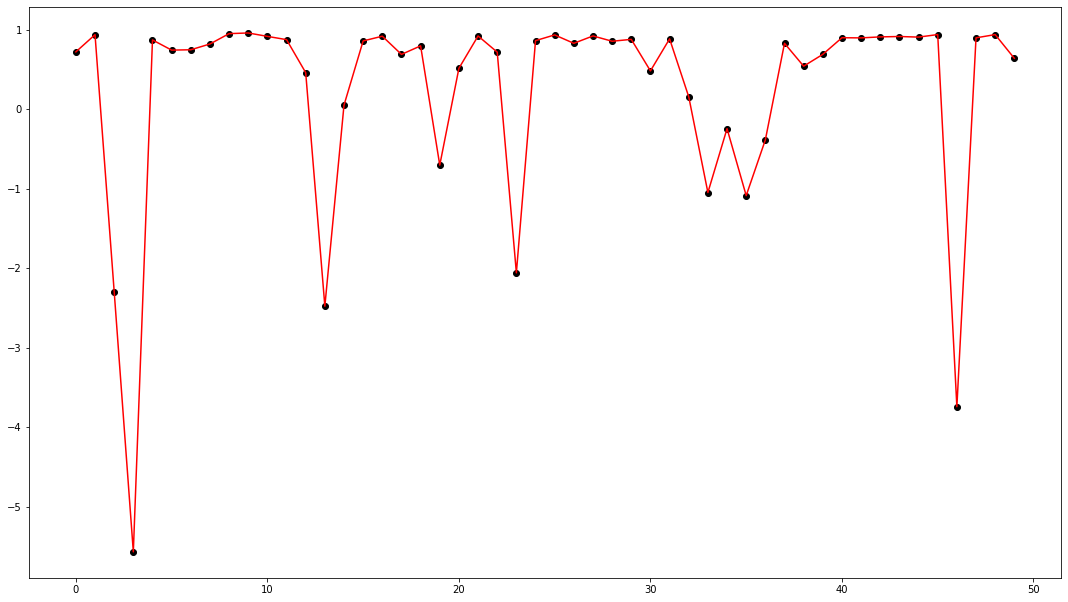

In [10]:
print(f'Los resultados presentan una media de {np.mean(scores)} y una desviación estándar de {np.std(scores)}.')
fig, ax1 =  plt.subplots()
ax1.plot(splits, scores, 'ok')
ax1.plot(splits, scores, 'r')
fig.set_size_inches(18.5, 10.5, forward=True)

# Graficamos las predicciones para el último split

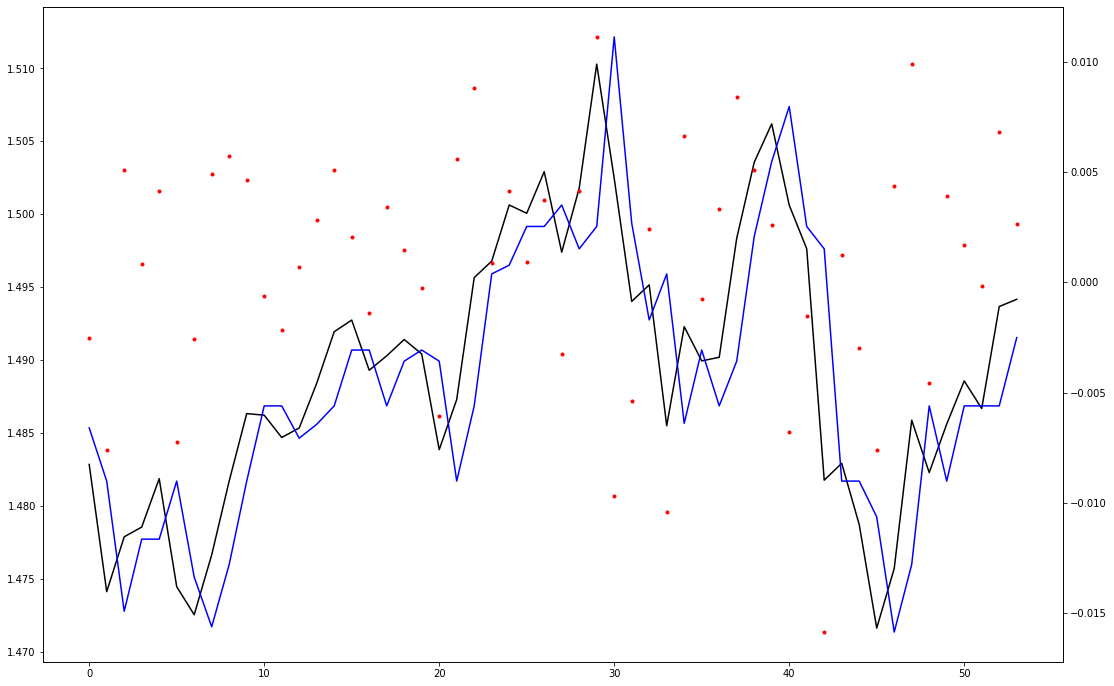

In [11]:
prediction = reg.predict(X_test)
fig, ax1 = plt.subplots()
ax1.plot(y_test, 'k')
ax1.plot(prediction, 'b')
ax2 = ax1.twinx()
ax2.plot(y_test-prediction, 'r.')
fig.tight_layout()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()

# El modelo es muy dependiente de cuándo se empieza a entrenar, por lo que se almacena junto al modelo la serie de datos de mercado, y los últimos splits de entrenamiento y test

In [ ]:
import pickle

In [ ]:
dict_variables = {}
dict_variables['market_data'] = X
dict_variables['market_target'] = y
dict_variables['train_index'] = train_index
dict_variables['test_index'] = test_index
dict_variables['modelo'] = reg

In [ ]:
with open('dictionary_model.pickle', 'wb') as handle:
    pickle.dump(dict_variables, handle, protocol=pickle.HIGHEST_PROTOCOL)

# para cargarlo
#with open('filename.pickle', 'rb') as handle:
#    b = pickle.load(handle)

In [ ]:
import boto3

In [ ]:
s3 = boto3.resource('s3')
s3.meta.client.upload_file('dictionary_model.pickle', 'sagemakerbmeironia', 'sagemaker_model/dictionary_model.pickle')